In [ ]:
import os, pandas, platform, torch, torchvision, pytorch_lightning
import torchvision.models as models
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchvision import datasets, transforms
from pytorch_lightning.loggers import CSVLogger

from torchmetrics import Accuracy, Precision, Recall

from utils import download_and_extract_repo

torch.manual_seed(42)

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| pytorch_lightning", pytorch_lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.10.11 | torch 2.4.1+cu121 | torchvision 0.19.1+cu121 | pytorch_lightning 2.5.0.post0 | pandas 2.2.1


In [23]:
data_path = "data"
data_folder = "train"
data_repo_user = "alexeygrigorev"
data_repo_name = "clothing-dataset-small"
if not os.path.exists(os.path.join(data_path, data_repo_name)):
    download_and_extract_repo(data_repo_user, data_repo_name, data_path)
    print("Downloaded dataset", data_repo_name)
else:
    print("The dataset", data_repo_name, "was found locally, no need to download it.")
data_path = os.path.join(data_path, data_repo_name, data_folder)
print("Using", data_path)

The dataset clothing-dataset-small was found locally, no need to download it.
Using data\clothing-dataset-small\train


## Create a dataset

In [24]:
class ImageFolderDataSet(LightningDataModule):
    def __init__(self, path, split=[.6, .2, .2], img_size=(224,224), batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.path = path
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def classes(self):
        return self.data.classes



dataset = ImageFolderDataSet(data_path)
dataset.setup()
classes = dataset.classes()
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['dress', 'hat', 'longsleeve', 'outwear', 'pants', 'shirt', 'shoes', 'shorts', 'skirt', 't-shirt']


## Create a model

In [25]:
class ImageClassifierModel(LightningModule):
    def __init__(self, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet18(weights="DEFAULT")
        if freeze_layers:
            for param in self.model.parameters(): param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.precision = Precision(task="multiclass", num_classes=self.num_classes, average="macro")
        self.recall = Recall(task="multiclass", num_classes=self.num_classes, average="macro") 
       
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch):
        x, y = batch
        out = self(x)
        return self.criterion(out, y)
    
    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        self.log("val_loss", self.criterion(out, y))
    
    def test_step(self, batch):
        x, y = batch
        out = self(x)
        preds = out.argmax(dim=1)
        self.log("test_accuracy", self.accuracy(preds, y), on_step=False, on_epoch=True)
        self.log("test_precision", self.precision(preds, y), on_step=False, on_epoch=True)    
        self.log("test_recall", self.recall(preds, y), on_step=False, on_epoch=True)
    
    #def predict_step(self, batch):
    #    x, y = batch
    #    return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002) 



model = ImageClassifierModel(num_classes=len(classes))

In [26]:
logger = CSVLogger(save_dir=".")
stop = EarlyStopping(monitor="val_loss")
trainer = Trainer(max_epochs=-1, logger=logger, callbacks=[stop])
trainer.fit(model, datamodule=dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 58/58 [00:02<00:00, 25.50it/s, v_num=8]          


## Stats

In [27]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))

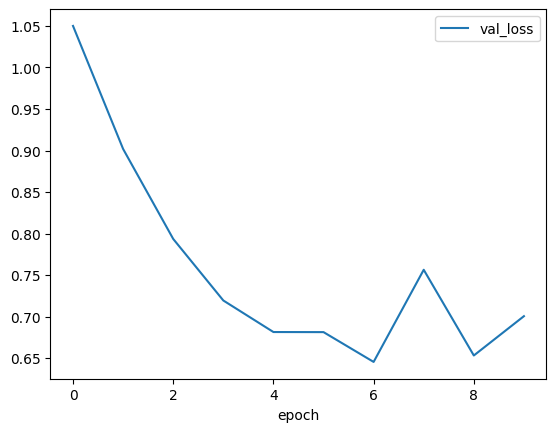

In [28]:
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

## Test

In [29]:
score = trainer.test(model, datamodule=dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 28.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8727569580078125
     test_precision         0.8556006550788879
       test_recall          0.8414777517318726
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# Inference

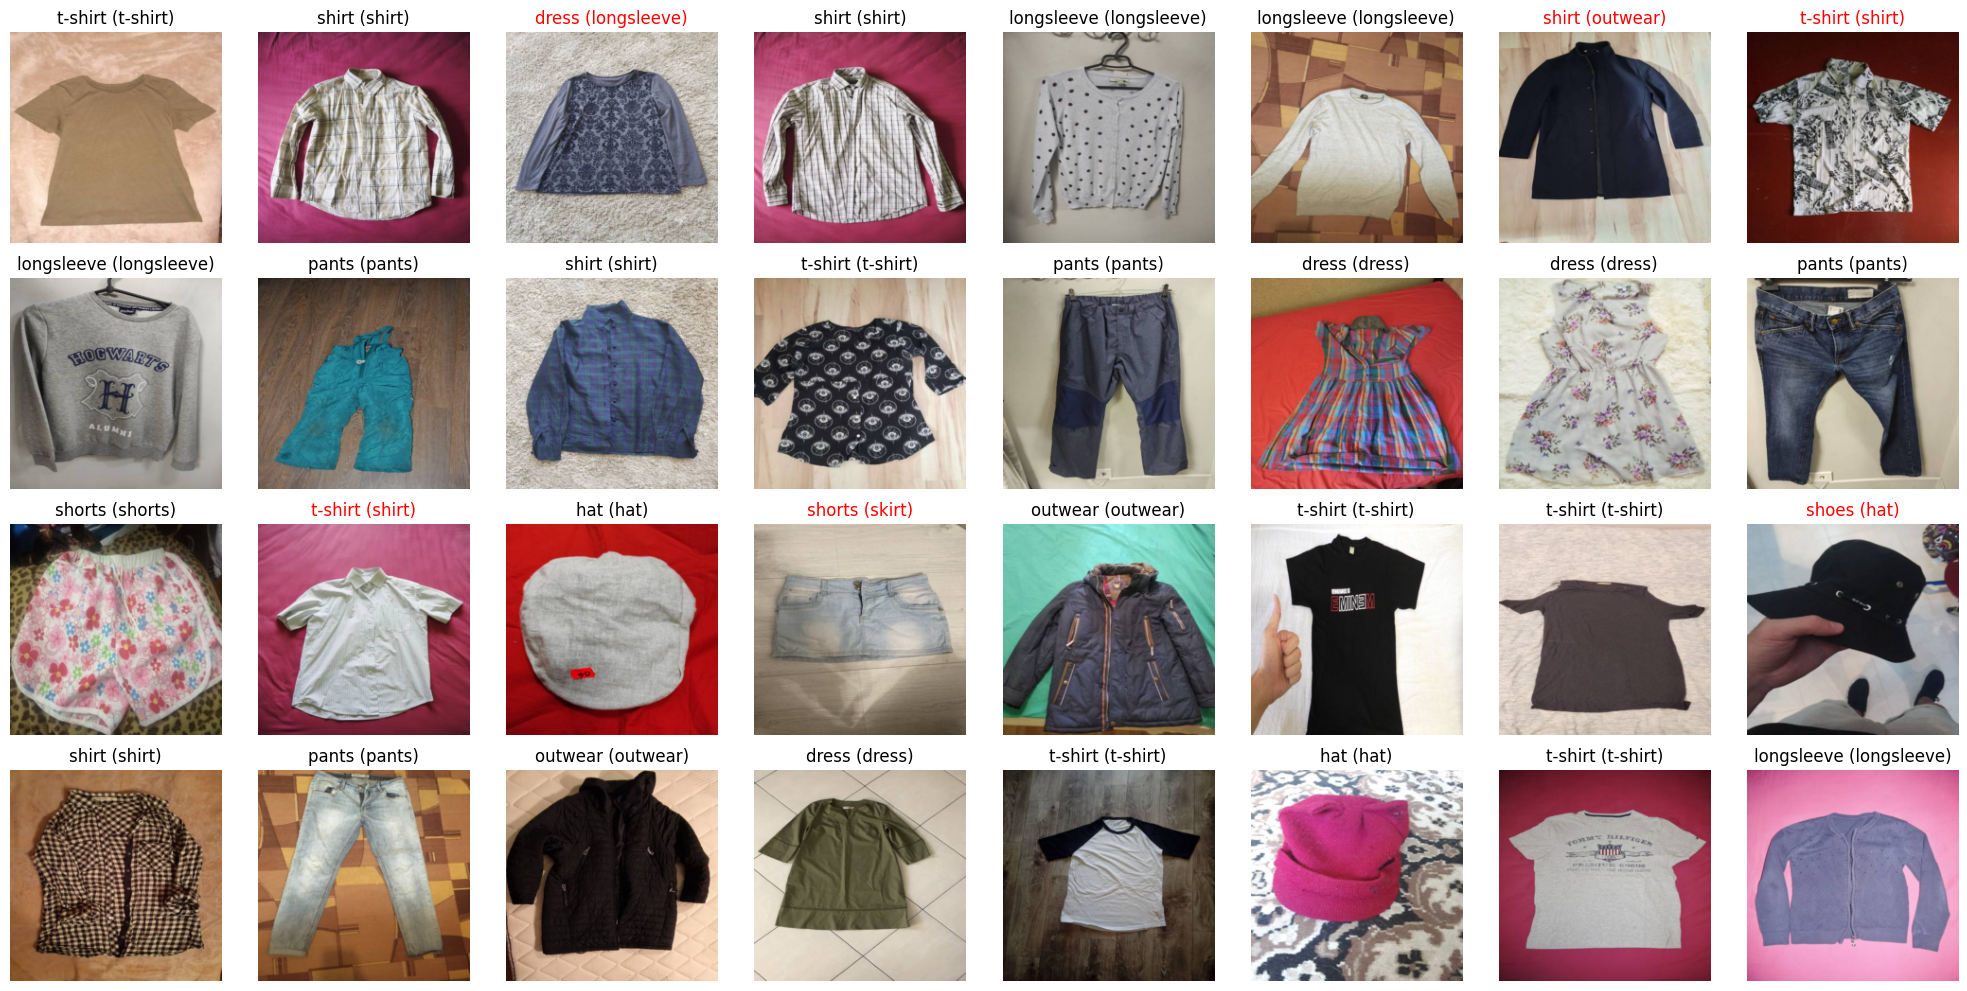

In [40]:
batch = next(iter(dataset.test_dataloader()))
images = batch[0]
labels = batch[1]
predictions = model(images)

fig, axs = plt.subplots(4, 8, figsize=(20, 10))
axs = axs.flatten()
for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    pred_label = classes[torch.argmax(prediction).item()]
    truth_label = classes[truth.item()]
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(pred_label + " ("+ truth_label+")", color="red" if pred_label != truth_label else "black")
    axs[i].axis("off")
plt.tight_layout()
plt.show()